<a href="https://colab.research.google.com/github/igopalakrishna/AI-assistant/blob/main/hpml_proj_lora_peft_alpaca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- Install Libraries ---
!pip install transformers datasets peft torchinfo timm -q
!pip install nvidia-ml-py3 -q

In [2]:
# --- Imports ---
import os
import torch
import torch.nn as nn
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    Trainer, TrainingArguments,
    DataCollatorForLanguageModeling
)
from datasets import load_dataset
from torchinfo import summary
from peft import LoraConfig, get_peft_model
from timm.layers import LayerNorm2d

In [3]:
# --- Setup Tokenizer and Base Model ---
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained("distilgpt2")
model.config.pad_token_id = tokenizer.pad_token_id

In [6]:
# --- Dynamic Tanh ---
class DynamicTanh(nn.Module):
    def __init__(self, normalized_shape, channels_last, alpha_init_value=0.5):
        super().__init__()
        self.normalized_shape = normalized_shape
        self.alpha_init_value = alpha_init_value
        self.channels_last = channels_last

        self.alpha = nn.Parameter(torch.ones(1) * alpha_init_value)
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))

    def forward(self, x):
        x = torch.tanh(self.alpha * x)
        if self.channels_last:
            x = x * self.weight + self.bias
        else:
            x = x * self.weight[:, None, None] + self.bias[:, None, None]
        return x

    def extra_repr(self):
        return f"normalized_shape={self.normalized_shape}, alpha_init_value={self.alpha_init_value}, channels_last={self.channels_last}"


def convert_ln_to_dyt(module):
    module_output = module
    if isinstance(module, nn.LayerNorm):
        module_output = DynamicTanh(module.normalized_shape, not isinstance(module, LayerNorm2d))
    for name, child in module.named_children():
        module_output.add_module(name, convert_ln_to_dyt(child))
    del module
    return module_output

In [7]:
model = convert_ln_to_dyt(model)

In [8]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): DynamicTanh(normalized_shape=(768,), alpha_init_value=0.5, channels_last=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): DynamicTanh(normalized_shape=(768,), alpha_init_value=0.5, channels_last=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): DynamicTanh(normalized_shape=(768,), alpha_init_value=0.5, channels_last=True)
  )
  (lm_head): Linear(in_features=768, out_features=5

In [9]:
# --- Summary ---
from torchinfo import summary

summary(model, input_size=(1, 128), dtypes=[torch.int64])

Layer (type:depth-idx)                             Output Shape              Param #
GPT2LMHeadModel                                    [1, 12, 128, 64]          --
├─GPT2Model: 1-1                                   [1, 12, 128, 64]          --
│    └─Embedding: 2-1                              [1, 128, 768]             38,597,376
│    └─Embedding: 2-2                              [1, 128, 768]             786,432
│    └─Dropout: 2-3                                [1, 128, 768]             --
│    └─ModuleList: 2-4                             --                        --
│    │    └─GPT2Block: 3-1                         [1, 128, 768]             7,087,874
│    │    └─GPT2Block: 3-2                         [1, 128, 768]             7,087,874
│    │    └─GPT2Block: 3-3                         [1, 128, 768]             7,087,874
│    │    └─GPT2Block: 3-4                         [1, 128, 768]             7,087,874
│    │    └─GPT2Block: 3-5                         [1, 128, 768]          

In [10]:
# --- PEFT Config (LoRA Injection) ---
peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["c_attn","fc_in", "fc_out"],  # DistilGPT2 uses c_attn in attention, # c_attn + MLP layers
    task_type="CAUSAL_LM",
)

In [11]:
peft_model = get_peft_model(model, peft_config)

/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1264: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [12]:
print("Trainable parameters after PEFT injection:")
peft_model.print_trainable_parameters()


Trainable parameters after PEFT injection:
trainable params: 147,456 || all params: 82,060,045 || trainable%: 0.1797


In [13]:
# --- Model Summary ---
summary(peft_model, input_size=(1, 128), dtypes=[torch.int64])

Layer (type:depth-idx)                                       Output Shape              Param #
PeftModelForCausalLM                                         [1, 12, 128, 64]          --
├─LoraModel: 1-1                                             [1, 12, 128, 64]          --
│    └─GPT2LMHeadModel: 2-1                                  --                        --
│    │    └─GPT2Model: 3-1                                   [1, 12, 128, 64]          82,060,045
│    │    └─Linear: 3-2                                      [1, 128, 50257]           (38,597,376)
Total params: 120,657,421
Trainable params: 147,456
Non-trainable params: 120,509,965
Total mult-adds (Units.GIGABYTES): 81.71
Input size (MB): 0.00
Forward/backward pass size (MB): 119.93
Params size (MB): 482.63
Estimated Total Size (MB): 602.56

In [15]:
# --- Load Alpaca Dataset ---
dataset = load_dataset("tatsu-lab/alpaca", split="train")

README.md:   0%|          | 0.00/7.47k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


(…)-00000-of-00001-a09b74b3ef9c3b56.parquet:   0%|          | 0.00/24.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/52002 [00:00<?, ? examples/s]

In [16]:
print(dataset)

Dataset({
    features: ['instruction', 'input', 'output', 'text'],
    num_rows: 52002
})


In [17]:
print(dataset.features)

{'instruction': Value(dtype='string', id=None), 'input': Value(dtype='string', id=None), 'output': Value(dtype='string', id=None), 'text': Value(dtype='string', id=None)}


In [18]:
def preprocess(batch):
    sources = []
    targets = []

    for instr, inp, outp in zip(batch['instruction'], batch['input'], batch['output']):
        if inp.strip() != "":
            prompt = instr.strip() + "\n\n" + inp.strip()
        else:
            prompt = instr.strip()
        sources.append(prompt)
        targets.append(outp.strip())

    full_texts = [s + "\n\n" + t for s, t in zip(sources, targets)]

    tokenized_batch = tokenizer(
        full_texts,
        truncation=True,
        padding="max_length",
        max_length=512,
    )

    return tokenized_batch


In [20]:
tokenized_dataset = dataset.map(
    preprocess,
    batched=True,
    remove_columns=dataset.column_names,
    desc="Tokenizing Alpaca dataset"
)

Tokenizing Alpaca dataset:   0%|          | 0/52002 [00:00<?, ? examples/s]

In [21]:
print(tokenized_dataset[0])

{'input_ids': [23318, 1115, 9040, 329, 10589, 5448, 13, 198, 198, 16, 13, 47659, 257, 12974, 5496, 290, 787, 1654, 284, 2291, 6088, 286, 15921, 290, 13701, 13, 220, 198, 17, 13, 32900, 7987, 284, 1394, 534, 1767, 4075, 290, 1913, 13, 220, 198, 18, 13, 3497, 1576, 3993, 290, 5529, 257, 6414, 3993, 7269, 13, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,

In [24]:
for i in range(5):
    print("Original instruction:")
    print(dataset[i]['instruction'])
    print("Original input:")
    print(dataset[i]['input'])
    print("Original output:")
    print(dataset[i]['output'])
    print("\nTokenized and Decoded Text:")
    print(tokenizer.decode(tokenized_dataset[i]['input_ids'], skip_special_tokens=True))
    print("=" * 80)


Original instruction:
Give three tips for staying healthy.
Original input:

Original output:
1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. 
2. Exercise regularly to keep your body active and strong. 
3. Get enough sleep and maintain a consistent sleep schedule.

Tokenized and Decoded Text:
Give three tips for staying healthy.

1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. 
2. Exercise regularly to keep your body active and strong. 
3. Get enough sleep and maintain a consistent sleep schedule.
Original instruction:
What are the three primary colors?
Original input:

Original output:
The three primary colors are red, blue, and yellow.

Tokenized and Decoded Text:
What are the three primary colors?

The three primary colors are red, blue, and yellow.
Original instruction:
Describe the structure of an atom.
Original input:

Original output:
An atom is made up of a nucleus, which contains protons and neutrons, surrounded by

In [25]:
split_datasets = tokenized_dataset.train_test_split(test_size=0.05, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

In [26]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

In [33]:
# # --- Compute Metrics (Perplexity instead of Accuracy) ---
# import math
# import numpy as np

# def compute_metrics(eval_preds):
#     preds, labels = eval_preds
#     loss = np.mean((preds - labels) ** 2)  # Dummy fallback, but we will ignore

#     # Hugging Face actually provides loss separately
#     try:
#         perplexity = math.exp(loss)
#     except OverflowError:
#         perplexity = float("inf")

#     return {
#         "eval_loss": loss,
#         "eval_perplexity": perplexity,
#     }


In [39]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="steps",
    eval_steps=500,  # Evaluate every 500 steps
    save_strategy="steps",
    save_steps=1000,  # Save every 1000 steps
    save_total_limit=2,  # Keep last 2 checkpoints
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_ratio=0.1,
    # warmup_steps=500,
    lr_scheduler_type="cosine",  # Smooth LR decay
    optim="adamw_torch",
    weight_decay=0.01,
    learning_rate=5e-5, # SMALL LR for GPT-2 finetuning
    fp16=True,
    logging_dir="./logs",
    logging_steps=100,
    report_to="none",  # disable WandB
)

In [40]:
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [41]:
for name, param in peft_model.named_parameters():
    if param.requires_grad:
        print(name)


base_model.model.transformer.h.0.attn.c_attn.lora_A.default.weight
base_model.model.transformer.h.0.attn.c_attn.lora_B.default.weight
base_model.model.transformer.h.1.attn.c_attn.lora_A.default.weight
base_model.model.transformer.h.1.attn.c_attn.lora_B.default.weight
base_model.model.transformer.h.2.attn.c_attn.lora_A.default.weight
base_model.model.transformer.h.2.attn.c_attn.lora_B.default.weight
base_model.model.transformer.h.3.attn.c_attn.lora_A.default.weight
base_model.model.transformer.h.3.attn.c_attn.lora_B.default.weight
base_model.model.transformer.h.4.attn.c_attn.lora_A.default.weight
base_model.model.transformer.h.4.attn.c_attn.lora_B.default.weight
base_model.model.transformer.h.5.attn.c_attn.lora_A.default.weight
base_model.model.transformer.h.5.attn.c_attn.lora_B.default.weight


In [42]:
trainer.train()

Step,Training Loss,Validation Loss
500,10.300100,10.136467
1000,9.754600,9.574805
1500,9.289200,9.088112
2000,8.978500,8.763642
2500,8.806100,8.583301
3000,8.746200,8.467399


Step,Training Loss,Validation Loss
500,10.300100,10.136467
1000,9.754600,9.574805
1500,9.289200,9.088112
2000,8.978500,8.763642
2500,8.806100,8.583301
3000,8.746200,8.467399
3500,8.667500,8.412307
4000,8.628000,8.386672
4500,8.579800,8.370262
5000,8.573800,8.350014


TrainOutput(global_step=9264, training_loss=8.856004013298707, metrics={'train_runtime': 1084.9895, 'train_samples_per_second': 136.594, 'train_steps_per_second': 8.538, 'total_flos': 1.942962079368499e+16, 'train_loss': 8.856004013298707, 'epoch': 3.0})

In [43]:
import math

final_loss = trainer.evaluate()["eval_loss"]
final_perplexity = math.exp(final_loss)
print(f"Final Evaluation Perplexity: {final_perplexity}")


Final Evaluation Perplexity: 4068.6659252066584


In [45]:
!pip install matplotlib -q
import matplotlib.pyplot as plt
import numpy as np

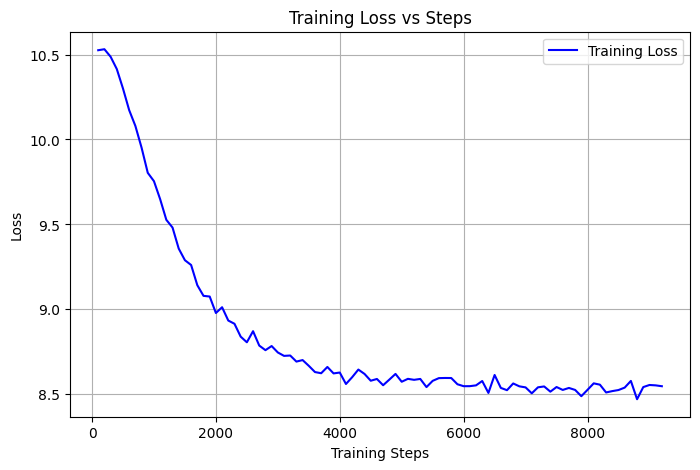

In [46]:
# Assume your logs are inside 'trainer.state.log_history'
train_loss_steps = []
train_losses = []

for record in trainer.state.log_history:
    if 'loss' in record and 'learning_rate' in record:  # skip eval loss entries
        train_loss_steps.append(record['step'])
        train_losses.append(record['loss'])

plt.figure(figsize=(8,5))
plt.plot(train_loss_steps, train_losses, label='Training Loss', color='blue')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss vs Steps')
plt.grid(True)
plt.legend()
plt.show()


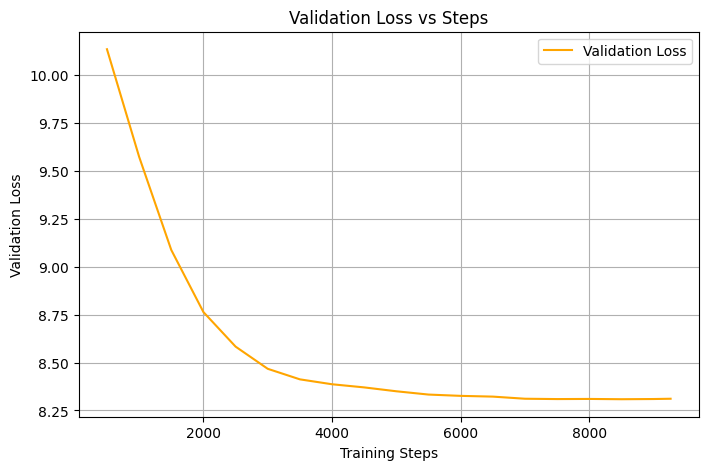

In [47]:
eval_loss_steps = []
eval_losses = []

for record in trainer.state.log_history:
    if 'eval_loss' in record:
        eval_loss_steps.append(record['step'])
        eval_losses.append(record['eval_loss'])

plt.figure(figsize=(8,5))
plt.plot(eval_loss_steps, eval_losses, label='Validation Loss', color='orange')
plt.xlabel('Training Steps')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Steps')
plt.grid(True)
plt.legend()
plt.show()


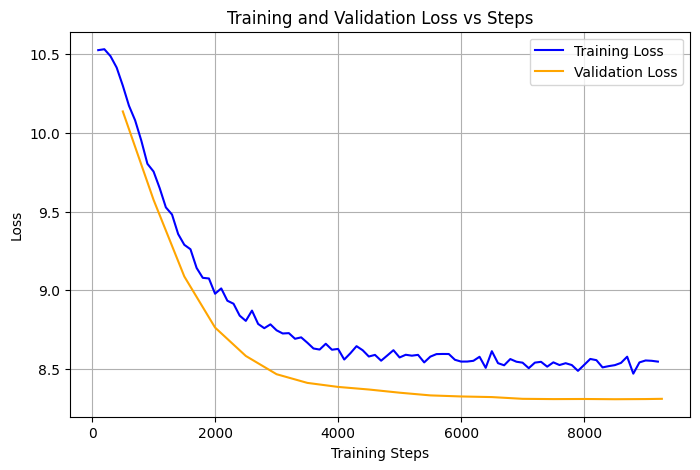

In [48]:
plt.figure(figsize=(8,5))
plt.plot(train_loss_steps, train_losses, label='Training Loss', color='blue')
plt.plot(eval_loss_steps, eval_losses, label='Validation Loss', color='orange')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Steps')
plt.grid(True)
plt.legend()
plt.show()


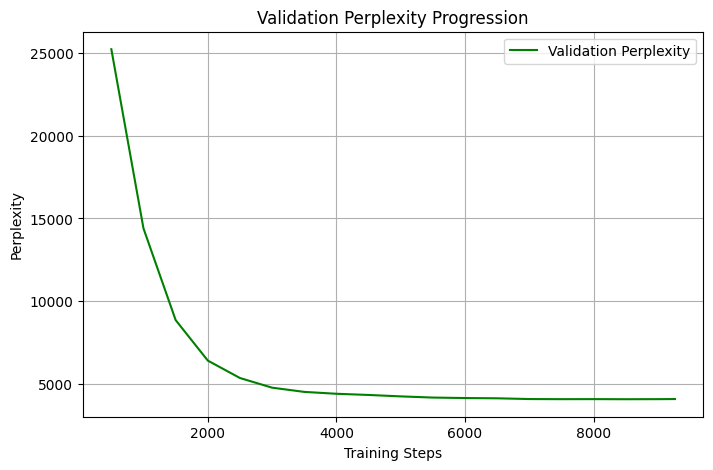

In [49]:
import math

perplexities = [math.exp(l) for l in eval_losses]

plt.figure(figsize=(8,5))
plt.plot(eval_loss_steps, perplexities, label='Validation Perplexity', color='green')
plt.xlabel('Training Steps')
plt.ylabel('Perplexity')
plt.title('Validation Perplexity Progression')
plt.grid(True)
plt.legend()
plt.show()


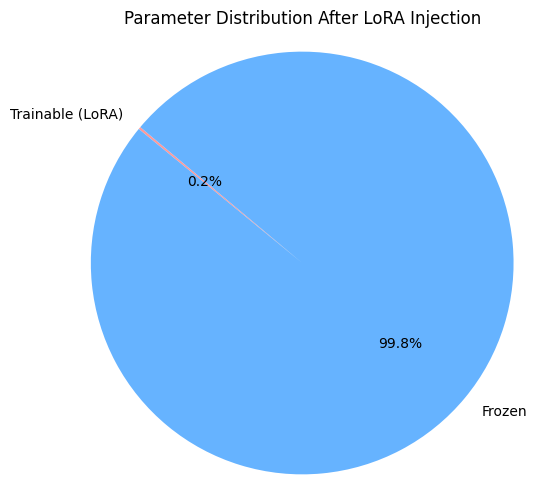

In [50]:
# Total params and trainable params were printed earlier by peft_model.print_trainable_parameters()
total_params = 82060181  # you printed this earlier for DistilGPT2 + LoRA
trainable_params = 147456  # (with LoRA)

frozen_params = total_params - trainable_params

labels = ['Trainable (LoRA)', 'Frozen']
sizes = [trainable_params, frozen_params]
colors = ['#ff9999','#66b3ff']

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Parameter Distribution After LoRA Injection')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [51]:
# # Function to generate text
# def generate_response(prompt, model, tokenizer, max_new_tokens=100):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model = model.to(device)
#     inputs = tokenizer(prompt, return_tensors="pt").to(device)
#     with torch.no_grad():
#         outputs = model.generate(**inputs, max_new_tokens=max_new_tokens)
#     decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
#     return decoded

# # Example
# prompt = "Explain how rainbows are formed."
# response = generate_response(prompt, peft_model, tokenizer)
# print(response)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Explain how rainbows are formed. the the



 the





 the
























































































In [54]:
def generate_response(prompt, model, tokenizer, max_new_tokens=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,               # <--- ENABLE SAMPLING
            temperature=0.7,               # <--- Slight randomness (lower = safer)
            top_k=50,                      # <--- Top-k sampling
            top_p=0.95,                    # <--- Nucleus sampling (optional)
            num_return_sequences=1         # <--- Only 1 output
        )

    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return decoded


In [ ]:
prompt = "Explain how rainbows are formed."


In [56]:
# response = generate_response(prompt, peft_model, tokenizer)
# print(response)


In [57]:
trainer.save_model("./distilgpt2_alpaca_peft")
tokenizer.save_pretrained("./distilgpt2_alpaca_peft")

('./distilgpt2_alpaca_peft/tokenizer_config.json',
 './distilgpt2_alpaca_peft/special_tokens_map.json',
 './distilgpt2_alpaca_peft/vocab.json',
 './distilgpt2_alpaca_peft/merges.txt',
 './distilgpt2_alpaca_peft/added_tokens.json',
 './distilgpt2_alpaca_peft/tokenizer.json')

In [58]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("./distilgpt2_alpaca_peft")

# Load base model (DistilGPT2 first)
base_model = AutoModelForCausalLM.from_pretrained("distilgpt2")

# Load PEFT fine-tuned model weights
model = PeftModel.from_pretrained(base_model, "./distilgpt2_alpaca_peft")

# Make sure padding token is correctly set (important)
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id

print("Model and tokenizer successfully loaded!")


Model and tokenizer successfully loaded!


In [59]:
def generate_response(prompt, model, tokenizer, max_new_tokens=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.7,
            top_k=50,
            top_p=0.95,
            num_return_sequences=1
        )

    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return decoded


In [61]:
prompt = "Explain how rainbows are formed."
response = generate_response(prompt, model, tokenizer)
print(response)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Explain how rainbows are formed. If we can get at least a little more detail on this, I think we can get a little more detailed on the origin of these shapes.

What are your thoughts on the shape of the shapes?
I am always fascinated by how the shape of the shapes, to the point of a "tree", can be used to make a shape.
The tree can be used to make a shape, to the point of a "tree", can be used to make a shape.
What
